In [11]:
import os, sys, urllib, gzip
import cPickle as pickle
sys.setrecursionlimit(10000)
import glob
from IPython.display import clear_output

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from IPython.display import Image as IPImage
from PIL import Image

In [13]:
from lasagne.layers import get_output, InputLayer, DenseLayer, Upscale2DLayer, ReshapeLayer
from lasagne.nonlinearities import rectify, leaky_rectify, tanh
from lasagne.updates import nesterov_momentum
from lasagne.objectives import categorical_crossentropy
from nolearn.lasagne import NeuralNet, BatchIterator, PrintLayerInfo

In [14]:
from lasagne.layers import Conv2DLayer as Conv2DLayer
from lasagne.layers import MaxPool2DLayer as MaxPool2DLayer

In [18]:
ch = 1
im = Image.open('../pics2/out1.png')
print im.size
if ch == 1:
    im = im.convert('L')
X = np.asarray(im.getdata()).reshape(112,112,ch).transpose(2,1,0) / 255.
X = X.reshape(-1,ch,112,112)
n = 0
for filename in glob.glob("../pics2/*.png"):
    n = n + 1
    im = Image.open(filename)
    Xim = np.asarray(im.getdata()).reshape(112,112,ch).transpose(2,1,0) / 255.
    Xim = Xim.reshape(-1,ch,112,112)
    X = np.concatenate((X, Xim), axis=0)
    if n==300:
        break
    
print 'X type and shape:', X.dtype, X.shape
print 'X.min():', X.min()
print 'X.max():', X.max()

(112, 112)
X type and shape: float64 (301, 1, 112, 112)
X.min(): 0.0
X.max(): 1.0


In [19]:
# we need our target to be 1 dimensional
X_out = X.reshape((X.shape[0], -1))
print 'X_out:', X_out.dtype, X_out.shape

X_out: float64 (301, 12544)


In [20]:
conv_num_filters = 16
filter_size = 3
pool_size = 2
encode_size = 16
dense_mid_size = 128
pad_in = 'valid'
pad_out = 'full'
layers = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}), 
    (Conv2DLayer, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (Conv2DLayer, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayer, {'pool_size': pool_size}),
    (Conv2DLayer, {'num_filters': 2*conv_num_filters, 'filter_size': filter_size, 'pad': pad_in}),
    (MaxPool2DLayer, {'pool_size': pool_size}),
    (ReshapeLayer, {'shape': (([0], -1))}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'name': 'encode', 'num_units': encode_size}),
    (DenseLayer, {'num_units': dense_mid_size}),
    (DenseLayer, {'num_units': 21632}),
    (ReshapeLayer, {'shape': (([0], 2*conv_num_filters, 26, 26))}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayer, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Upscale2DLayer, {'scale_factor': pool_size}),
    (Conv2DLayer, {'num_filters': conv_num_filters, 'filter_size': filter_size, 'pad': pad_out}),
    (Conv2DLayer, {'num_filters': 1, 'filter_size': filter_size, 'pad': pad_out}),
    (ReshapeLayer, {'shape': (([0], -1))}),
]

In [21]:
ae = NeuralNet(
    layers=layers,
    max_epochs=20,
    
    update=nesterov_momentum,
    update_learning_rate=0.01,
    update_momentum=0.975,
    
    regression=True,
    verbose=1
)
# ae.initialize()
# PrintLayerInfo()(ae)

In [22]:
ae.fit(X, X_out)

# Neural Network with 5578001 learnable parameters

## Layer information

  #  name         size
---  -----------  ----------
  0  input0       1x112x112
  1  conv2d1      16x110x110
  2  conv2d2      16x108x108
  3  maxpool2d3   16x54x54
  4  conv2d4      32x52x52
  5  maxpool2d5   32x26x26
  6  reshape6     21632
  7  dense7       128
  8  encode       16
  9  dense9       128
 10  dense10      21632
 11  reshape11    32x26x26
 12  upscale2d12  32x52x52
 13  conv2d13     16x54x54
 14  upscale2d14  16x108x108
 15  conv2d15     16x110x110
 16  conv2d16     1x112x112
 17  reshape17    12544

  epoch    train loss    valid loss    train/val  dur
-------  ------------  ------------  -----------  ------
      1       0.03394       0.06502      0.52207  53.16s
      2       0.02975       0.05409      0.55010  50.17s
      3       0.02393       0.04246      0.56360  56.89s
      4       0.01949       0.03316      0.58794  49.69s
      5       0.01800       0.02743      0.65608  49.37s
      

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x10d591450>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x10d5913d0>,
     custom_score=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 112, 112)}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 3, 'pad': 'valid', 'num_filters': 16}), (<class 'lasagne.layers.conv.Conv2DLayer'>, {'filter_size': 3, 'pad': 'valid', 'num_filters': 16}), (<class 'lasagn...d': 'full', 'num_filters': 1}), (<class 'lasagne.layers.shape.ReshapeLayer'>, {'shape': ([0], -1)})],
     loss=None, max_epochs=20, more_params={},
     objective=<function objective at 0x10d593500>,
     objective_loss_function=<function squared_error at 0x10d2f0398>,
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x10e0e76c8>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instance at 0

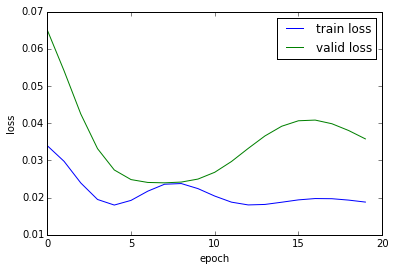

In [23]:
from nolearn.lasagne.visualize import plot_loss
plot_loss(ae)